In [1]:
import ROOT
import os

Welcome to JupyROOT 6.25/01


In [2]:
from dask_remote_jobqueue import RemoteHTCondor
cluster = RemoteHTCondor()

In [3]:
from dask.distributed import Client

client = Client(address="tcp://127.0.0.1:"+str(cluster.sched_port))

In [4]:
text_file = open("postselection.h", "r")
data = text_file.read()

In [5]:
distributed = ROOT.RDF.Experimental.Distributed

def my_initialization_function():
    ROOT.gInterpreter.Declare('{}'.format(data))
    
distributed.initialize(my_initialization_function)

input_line_48:616:1: warning: control may reach end of non-void function [-Wreturn-type]
}
^


In [6]:
def filter_trigger(df):
    df_goodvertex = df.Filter("Flag_goodVertices && Flag_globalSuperTightHalo2016Filter && Flag_HBHENoiseFilter && Flag_HBHENoiseIsoFilter && Flag_EcalDeadCellTriggerPrimitiveFilter && Flag_BadPFMuonFilter && Flag_ecalBadCalibFilterV2", "Good vertex selection")
    df_trigger = df_goodvertex.Filter("HLT_IsoMu27 || HLT_Mu50 || HLT_Ele35_WPTight_Gsf || HLT_Ele32_WPTight_Gsf_L1DoubleEG || HLT_Photon200", "Leptonic trigger")
    return df_trigger

def select_jets(df):
    df_atleast2Jets = df.Filter("nJet>2", "At least two jets")
    df_GoodJets = df_atleast2Jets.Define("GoodJets_idx", "GoodJets(Jet_jetId, Jet_eta, Jet_pt, Jet_puId)")
    df_atleast2GoodJets = df_GoodJets.Filter("atleast2GoodJets(GoodJets_idx)", "At least two good jets")
    df_VBSjets = df_atleast2GoodJets.Define("VBSJet_idx", "SelectVBSJets_invmass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, GoodJets_idx)")
    df_2VBSjets = df_VBSjets.Filter("VBSJet_idx[0] != VBSJet_idx[1]", "2 VBS jets")
    df_jetsDefinitions = df_2VBSjets.Define("Leadingjet_pt", "GetLeading(Jet_pt, VBSJet_idx)")\
                                    .Define("Leadingjet_eta", "GetLeading(Jet_eta, VBSJet_idx)")\
                                    .Define("Leadingjet_phi", "GetLeading(Jet_phi, VBSJet_idx)")\
                                    .Define("Leadingjet_mass", "GetLeading(Jet_mass, VBSJet_idx)")\
                                    .Define("Leadingjet_DeepFlv_b", "GetLeading(Jet_btagDeepFlavB, VBSJet_idx)")\
                                    .Define("Leadingjet_DeepCSVv2_b", "GetLeading(Jet_btagDeepB, VBSJet_idx)")\
                                    .Define("Leadingjet_CSVv2_b", "GetLeading(Jet_btagCSVV2, VBSJet_idx)")\
                                    .Define("SubLeadingjet_pt", "GetSubLeading(Jet_pt, VBSJet_idx)")\
                                    .Define("SubLeadingjet_eta", "GetSubLeading(Jet_eta, VBSJet_idx)")\
                                    .Define("SubLeadingjet_phi", "GetSubLeading(Jet_phi, VBSJet_idx)")\
                                    .Define("SubLeadingjet_mass", "GetSubLeading(Jet_mass, VBSJet_idx)")\
                                    .Define("SubLeadingjet_DeepFlv_b", "GetSubLeading(Jet_btagDeepFlavB, VBSJet_idx)")\
                                    .Define("SubLeadingjet_DeepCSVv2_b", "GetSubLeading(Jet_btagDeepB, VBSJet_idx)")\
                                    .Define("SubLeadingjet_CSVv2_b", "GetSubLeading(Jet_btagCSVV2, VBSJet_idx)")
    return df_jetsDefinitions

def select_lepton(df):
    df_selectElectron = df.Define("Electron_idx", "SelectElectron(Electron_pt, Electron_eta, Electron_phi, Electron_jetRelIso, Electron_mvaFall17V2Iso_WPL, Electron_mvaFall17V2Iso_WP90, Jet_eta, Jet_phi, VBSJet_idx)")
    df_selectMuon = df_selectElectron.Define("Muon_idx", "SelectMuon(Muon_pt, Muon_eta, Muon_phi, Muon_tightId, Muon_looseId, Muon_pfRelIso04_all, Jet_eta, Jet_phi, VBSJet_idx)")
    df_atLeast1Lepton = df_selectMuon.Filter("Electron_idx[1] != -1 || Muon_idx[1] != -1", "At least 1 at-least-loose lepton")
    df_goodLeptonFamily = df_atLeast1Lepton.Define("GoodLeptonFamily", "DetermineGoodLepton(HLT_IsoMu27, HLT_Mu50, HLT_Ele35_WPTight_Gsf, HLT_Ele32_WPTight_Gsf_L1DoubleEG, HLT_Photon200, HLT_PFHT250, HLT_PFHT350, Electron_idx, Electron_pt, Electron_eta, Electron_mvaFall17V2Iso_WPL, Electron_jetRelIso, Muon_idx, Muon_pt, Muon_eta, Muon_pfRelIso04_all, Muon_looseId)")
    df_compatibleLeptons = df_goodLeptonFamily.Filter("GoodLeptonFamily != -1 ", "Filter on leptons")
    df_leptonDefinitions = df_compatibleLeptons.Define("Lepton_pt", "GetLepton(Electron_pt, Electron_idx, Muon_pt, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_eta", "GetLepton(Electron_eta, Electron_idx, Muon_eta, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_phi", "GetLepton(Electron_phi, Electron_idx, Muon_phi, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_mass", "GetLepton(Electron_mass, Electron_idx, Muon_mass, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_charge", "GetLepton(Electron_charge, Electron_idx, Muon_charge, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_TightRegion", "GetLeptonTightFlag(Electron_idx, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_LnTRegion", "1 - Lepton_TightRegion")\
                                                .Define("Lepton_Zeppenfeld", "Zeppenfeld(Lepton_eta, Leadingjet_eta, SubLeadingjet_eta)")\
                                                .Define("Lepton_pdgId", "GetLepton(Electron_pdgId, Electron_idx, Muon_pdgId, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_SFFake_vsjet2", "SFFakeRatio_lep_calc_vsjet2(Lepton_pt, Lepton_eta, Lepton_pdgId)")\
                                                .Define("Lepton_SFFake_vsjet4", "SFFakeRatio_lep_calc_vsjet4(Lepton_pt, Lepton_eta, Lepton_pdgId)")\
    
    return df_leptonDefinitions

def select_tau(df):
    df_selectTau = df.Define("Tau_idx", "SelectAndVetoTaus(Tau_pt, Tau_eta, Tau_phi, Tau_idDeepTau2017v2p1VSjet, Tau_idDeepTau2017v2p1VSe, Tau_idDeepTau2017v2p1VSmu, Tau_idDecayModeNewDMs, GoodLeptonFamily, Electron_idx, Electron_eta, Electron_phi, Muon_idx, Muon_eta, Muon_phi, Jet_eta, Jet_phi, VBSJet_idx)")
    df_1tau = df_selectTau.Filter("Tau_idx[1] != -1", "Exactly 1 at least loose Tau")
    df_tauDefinitions = df_1tau.Define("SelectedTau_pt", "GetTau(Tau_pt, Tau_idx)")\
                               .Define("SelectedTau_eta", "GetTau(Tau_eta, Tau_idx)")\
                               .Define("SelectedTau_phi", "GetTau(Tau_phi, Tau_idx)")\
                               .Define("SelectedTau_mass", "GetTau(Tau_mass, Tau_idx)")\
                               .Define("SelectedTau_charge", "GetTau(Tau_charge, Tau_idx)")\
                               .Define("SelectedTau_relleadtkpt", "GetTau(Tau_leadTkPtOverTauPt, Tau_idx)")\
                               .Define("SelectedTau_decayMode", "GetTau(Tau_decayMode, Tau_idx)")\
                               .Define("SelectedTau_isolation", "GetTau(Tau_neutralIso, Tau_idx)")\
                               .Define("SelectedTau_DeepTau_WP", "pow(GetTau(Tau_idDeepTau2017v2p1VSjet, Tau_idx)*1000., 2) + GetTau(Tau_idDeepTau2017v2p1VSjet, Tau_idx)*1000. + GetTau(Tau_idDeepTau2017v2p1VSe, Tau_idx)*1000.")\
                               .Define("SelectedTau_DeepTauVsEle_raw", "GetLog2(GetTau(Tau_idDeepTau2017v2p1VSe, Tau_idx) + 1)")\
                               .Define("SelectedTau_DeepTauVsMu_raw", "GetLog2(GetTau(Tau_idDeepTau2017v2p1VSmu, Tau_idx) + 1)")\
                               .Define("SelectedTau_DeepTauVsJet_raw", "GetLog2(GetTau(Tau_idDeepTau2017v2p1VSjet, Tau_idx) + 1)")\
                               .Define("SelectedTau_GenMatch", "GetTau(Tau_genPartFlav, Tau_idx)")\
                               .Define("SelectedTau_Zeppenfeld", "Zeppenfeld(SelectedTau_eta, Leadingjet_eta, SubLeadingjet_eta)")\
                               .Define("SelectedTau_TightRegion", "Tau_idx[1]")\
                               .Define("SelectedTau_LnTRegion", "1 - Tau_idx[1]")\
                               .Define("SelectedTau_SFFake_vsjet2", "SFFakeRatio_tau_calc_vsjet2(SelectedTau_pt, SelectedTau_eta)")\
                               .Define("SelectedTau_SFFake_vsjet4", "SFFakeRatio_tau_calc_vsjet4(SelectedTau_pt, SelectedTau_eta)")
    
    return df_tauDefinitions

def general_definitions(df):
    df_definitions = df.Define("mjj", "GetInvMass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, VBSJet_idx)")\
                       .Define("deltaPhi_jj", "deltaPhi(Leadingjet_phi, SubLeadingjet_phi)")\
                       .Define("deltaPhi_taulep", "deltaPhi(SelectedTau_phi, Lepton_phi)")\
                       .Define("deltaPhi_tauj1", "deltaPhi(SelectedTau_phi, Leadingjet_phi)")\
                       .Define("deltaPhi_tauj2", "deltaPhi(Leadingjet_phi, SubLeadingjet_phi)")\
                       .Define("deltaPhi_lepj1", "deltaPhi(Lepton_phi, Leadingjet_phi)")\
                       .Define("deltaPhi_lepj2", "deltaPhi(Lepton_phi, SubLeadingjet_phi)")\
                       .Define("deltaEta_jj", "Leadingjet_eta - SubLeadingjet_eta")\
                       .Define("deltaEta_taulep", "SelectedTau_eta - Lepton_eta")\
                       .Define("deltaEta_tauj1", "SelectedTau_eta - Leadingjet_eta")\
                       .Define("deltaEta_tauj2", "SelectedTau_eta - SubLeadingjet_eta")\
                       .Define("deltaEta_lepj1", "Lepton_eta - Leadingjet_eta")\
                       .Define("deltaEta_lepj2", "Lepton_eta - SubLeadingjet_eta")\
                       .Define("deltaTheta_jj", "deltaTheta(Leadingjet_pt, Leadingjet_eta, Leadingjet_phi, Leadingjet_mass, SubLeadingjet_pt, SubLeadingjet_eta, SubLeadingjet_phi, SubLeadingjet_mass)")\
                       .Define("deltaTheta_taulep", "deltaTheta(SelectedTau_pt,SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, Lepton_pt, Lepton_eta, Lepton_phi, Lepton_mass)")\
                       .Define("deltaTheta_tauj1", "deltaTheta(SelectedTau_pt, SelectedTau_eta,SelectedTau_phi, SelectedTau_mass, Leadingjet_pt, Leadingjet_eta, Leadingjet_phi, Leadingjet_mass)")\
                       .Define("deltaTheta_tauj2", "deltaTheta(SelectedTau_pt, SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, SubLeadingjet_pt, SubLeadingjet_eta, SubLeadingjet_phi, SubLeadingjet_mass)")\
                       .Define("Event_Zeppenfeld", "0.5*(Lepton_Zeppenfeld + SelectedTau_Zeppenfeld)")\
                       .Define("Lepton_Zeppenfeld_over_deltaEta_jj", "Lepton_Zeppenfeld / deltaEta_jj")\
                       .Define("SelectedTau_Zeppenfeld_over_deltaEta_jj", "SelectedTau_Zeppenfeld / deltaEta_jj")\
                       .Define("Event_Zeppenfeld_over_deltaEta_jj", "Event_Zeppenfeld / deltaEta_jj")\
                       .Define("mTlepMET", "sqrt(2*Lepton_pt*MET_pt*(1-cos(Lepton_phi-MET_phi)))")\
                       .Define("m_1T", "M1T(Lepton_pt, Lepton_eta, Lepton_phi, Lepton_mass, SelectedTau_pt, SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, MET_pt, MET_phi)")\
                       .Define("m_o1", "Mo1(Lepton_pt, Lepton_eta, Lepton_phi, Lepton_mass, SelectedTau_pt, SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, MET_pt, MET_phi)")\
                       .Define("event_SFFake_vsjet2", "GetEventSFFake(Lepton_SFFake_vsjet2, SelectedTau_SFFake_vsjet2, Lepton_LnTRegion, SelectedTau_LnTRegion)")\
                       .Define("event_SFFake_vsjet4", "GetEventSFFake(Lepton_SFFake_vsjet4, SelectedTau_SFFake_vsjet4, Lepton_LnTRegion, SelectedTau_LnTRegion)")\
    
    
    return df_definitions

In [7]:
RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame

df = RDataFrame("Events",
                "https://ttedesch.web.cern.ch/ttedesch/tree_hadd_2.root",
                npartitions=2,
                daskclient=client)

In [8]:
#trigger and VBS jets selections
df_trigger = filter_trigger(df)
df_jets = select_jets(df_trigger)

#e/mu + tau final state
df_lepton = select_lepton(df_jets)
df_tau = select_tau(df_lepton)
df_SS = df_tau.Filter("SameCharge(GoodLeptonFamily, Electron_idx, Electron_charge, Muon_idx, Muon_charge, Tau_idx, Tau_charge)", "SameSign")
df_bVeto = df_SS.Filter("!BVeto(Jet_pt, Jet_eta, Jet_btagDeepFlavB, GoodJets_idx)", "Bveto")
df_definitions = general_definitions(df_bVeto)

##### signal region
df_mjjCut = df_definitions.Filter("mjj > 500", "mjj cut")
df_METCut = df_mjjCut.Filter("MET_pt > 50", "MET cut")

h = {}

h["Leadingjet_pt"] = df_METCut.Histo1D(("Leadingjet_pt", "Leadingjet_pt", 100, 0, 2000), "Leadingjet_pt")
h["Lepton_pt"] = df_METCut.Histo1D(("Lepton_pt", "Lepton_pt", 100, 0, 1000),"Lepton_pt")
h["SelectedTau_pt"] = df_METCut.Histo1D(("SelectedTau_pt", "SelectedTau_pt", 100, 0, 1000), "SelectedTau_pt")
h["deltaTheta_tauj2"] = df_METCut.Histo1D(("deltaTheta_tauj2", "deltaTheta_tauj2", 100, -1, 1), "deltaTheta_tauj2")

/usr/local/share/root6/lib/DistRDF/HeadNode.py:392: UserWarning: Number of partitions is greater than number of clusters in the dataset. Using 1 partition(s)
  return Node.RangesBuilder(self)._get_clustered_ranges(self.treename, self.inputfiles, self._get_friend_info())
Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


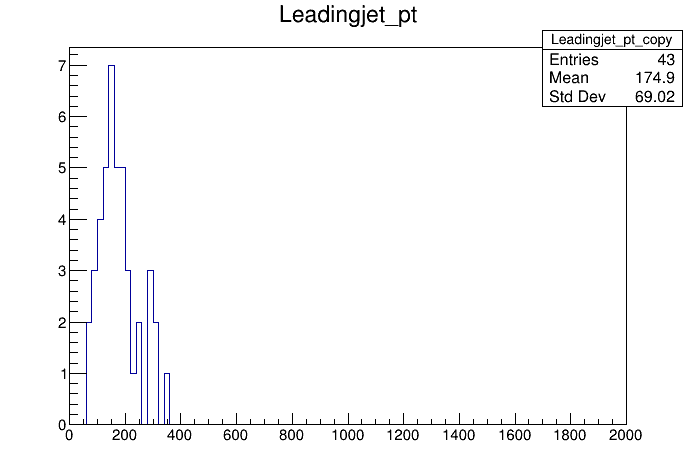

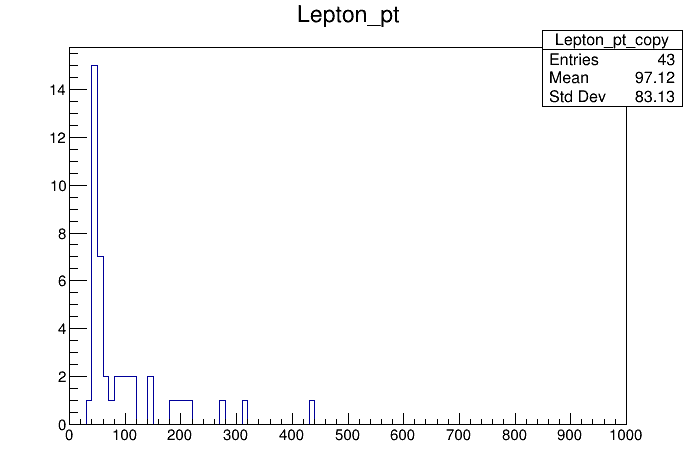

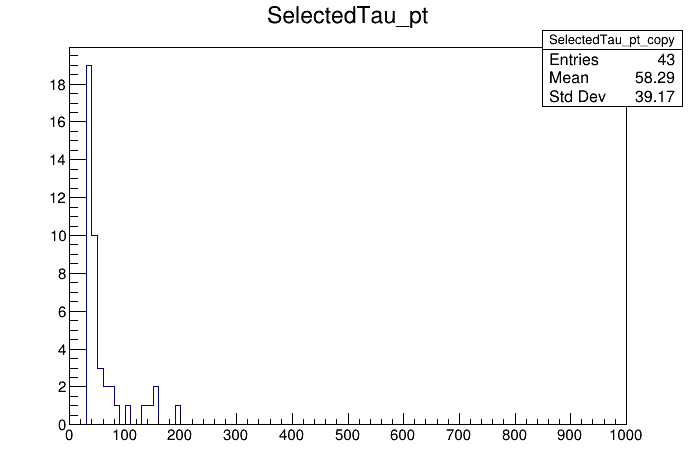

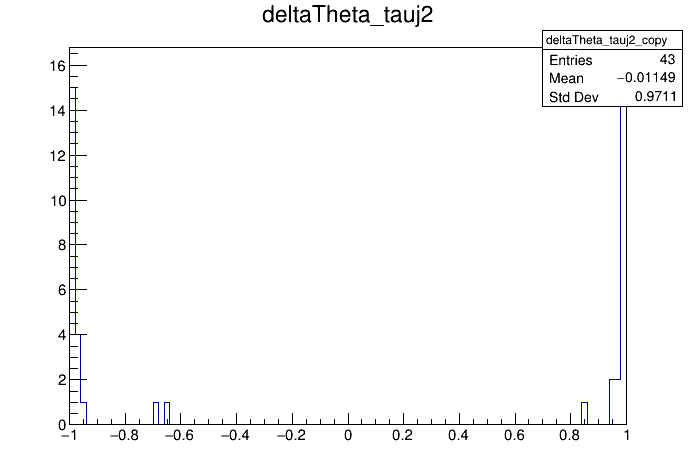

In [9]:
variables = ["Leadingjet_pt", "Lepton_pt","SelectedTau_pt", "deltaTheta_tauj2"]
canvases = []
legends = []

for i, v in enumerate(variables):
    canvases.append(ROOT.TCanvas())
    variable = variables[i]
    hist = h[variable]
    #integral = hist.Integral()
    #hist.Scale( 1./ integral,"WIDTH")
    hist = hist.DrawCopy('HIST')
    canvases[i].Draw()